## Task 1 Gaussian Process Regression

In [12]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, coo_matrix
from scipy.sparse.linalg import lsqr, spsolve
from scipy.linalg import solve_banded



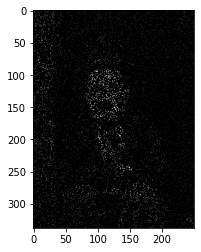

In [22]:
#load image from png file
from PIL import Image
img = Image.open('EML_ex07_material/cc_90.png')

#convert image to numpy array
img = np.asarray(img)/255


#plot image
plt.imshow(img, cmap='gray')
plt.show()


In [16]:
#implement gaussian process regression 

class GaussianProcessRegression:
    def __init__(self, kernel, noise=1e-3, g = 0.2, h = 0.2):
        self.kernel = kernel
        self.noise = noise #noise variance is 1e-3 by default
        self.h = h
        self.g = g
        self.X = None
        self.y = None
        self.K = None
        #self.K_inv = None
        self.A = None
        self.z = None

    def fit(self, X, y):
        self.X = X
        self.y = y

        #calculate kernel A matrix, cutoff when similarity at 1e-9
        sim = self.kernel(X[:, None], X[None, :], self.g, self.h)
        sim[sim < 1e-9] = 0
        
        #A matrix
        self.A = coo_matrix(sim)

        #find number of non-zero lower and upper diagonals
        # print(self.A.diagonal().shape)

        #make K sparse matrix to save memory
        self.K = self.A + self.noise * dok_matrix(np.eye(len(X)))
        
        #solve linear system to find z using spsolve
        self.z = spsolve(self.K, y)

        #solve linear system to find z using solve_banded efficiently but we will still use spsolve for now
        # p = 2000
        # ab = np.zeros((2*p+1, len(X)))
        # ab[p,:] = self.K.diagonal()
        # for i in range(1, p+1):
        #     ab[p-i, i:] = self.K.diagonal(i)
        #     ab[p+i, :-i] = self.K.diagonal(-i)
        # self.z = solve_banded((p, p), ab, y)


    def predict(self, X_star):
        B = self.kernel(self.X[:, None], X_star[None, :], self.g, self.h)
        y_pred = B.T @ self.z
        return y_pred

#kernel function
def generalized_exponential_kernel(x1, x2, g=0.02, h=0.5):
    #x1 and x2 are 2D arrays of shape n,1,2 and 1,n,2 respectively
    #so r will be of shape n,n as x1, x2 are broadcasted arrays
    r = np.sqrt(np.sum((x1-x2),axis=2)**2/h**2)
    return np.exp(-r**g)

In [17]:
#use image to create training data
X = np.argwhere(img != 0)
y = img[img != 0]

#test data where value is zero
X_star = np.argwhere(img == 0)


In [27]:
#create gaussian process regression object

# noise = 1e-7
noise = np.var(y) #noise variance is variance of training data
gpr = GaussianProcessRegression(generalized_exponential_kernel, noise=noise, g = 1,  h  = 0.02)

#fit gaussian process regression model
gpr.fit(X, y)

In [28]:
#predict values for test data
y_star = gpr.predict(X_star)

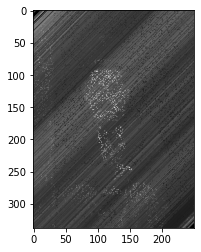

In [29]:
#plot predicted values
img_pred = np.zeros(img.shape)
img_pred[img == 0] = y_star
img_pred[img != 0] = y

plt.imshow(img_pred, cmap='gray')

In [122]:
a = generalized_exponential_kernel(X[:, None], X[None, :])
# a = coo_matrix(a)

In [30]:
#implement Nadaraya-Watson regression

class NadarayaWatsonRegression:
    def __init__(self, kernel, g = 0.2, h=0.2):
        self.kernel = kernel
        self.h = h
        self.g = g
        self.X = None
        self.y = None

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_star):
        b = self.kernel(self.X[:, None], X_star[None, :],self.g, self.h)
        y_pred = np.sum(b * self.y[:, None], axis=0) / np.sum(b, axis=0)
        return y_pred



In [31]:
nwr = NadarayaWatsonRegression(generalized_exponential_kernel, g = 1.5, h=0.2)
nwr.fit(X, y)


In [32]:
#predict values for remaining pixels
y_star = nwr.predict(X_star)
#plot predicted values
img_pred = np.zeros(img.shape)
img_pred[img == 0] = y_star
img_pred[img != 0] = y

plt.imshow(img_pred, cmap='gray')

In [8]:
y_star[:10]

array([160.99869339, 160.99889426, 160.99910028, 160.99931689,
       160.99958994, 160.98954744, 160.79049057, 157.6769572 ,
       146.08238245, 142.64399526])